In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

In [26]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
import tensorflow as tf
import keras.backend as K
import json
from keras.models import load_model
import random
from sklearn.cluster import DBSCAN
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
TIMEFORMAT = "%m-%d-%H:%M:%S"
GPU_MEMORY_FRACTION = 1.0
DATA_SHAPE = 224

In [23]:
def read_paths(dataset_path):
    imagepaths = []
    path_list = os.listdir(dataset_path)
    for path in tqdm(path_list):
        imagepaths.append(dataset_path + "%s"%path)
    return imagepaths

day_set_path = "vids/day_image/"
night_set_path = "vids/night_image/"
day_image_path = read_paths(day_set_path)
night_image_path = read_paths(night_set_path)

100%|██████████| 3600/3600 [00:00<00:00, 423476.96it/s]


# Pipeline

In [27]:
def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction
    sess = tf.Session(config=config)
    K.set_session(sess)
    
config_keras_backend(GPU_MEMORY_FRACTION)
seg_model = load_model('/home/mc16/model3/unet0625.h5')
cla_model = load_model('/home/mc16/zhy/Classification_Model/classifier_5.h5')

/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [30]:
def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]

def cut_top(mask, thresh, frac=0.04):
    cut_mask = np.array(mask)
    sum_mask = np.sum(mask, axis=1)
    top_index = 0
    for i in range(len(sum_mask)):
        if (sum_mask[i] > thresh):
            top_index = i
            break
    cut_index = top_index + int((224 - top_index) * frac)
    cut_mask[:cut_index,:] = 0
    return cut_mask, top_index

def cut_shit(mask, num, frac=0.7):
    cut_mask = np.array(mask)
    for j in range(224):
        for i in range(223-num):
            if np.sum(cut_mask[j, i:i+num]) > num*frac:
                cut_L = i + int(num * (1 - frac * 0.9))
                cut_R = i + int(num * (1 - frac * 0.1))
                cut_mask[j, cut_L:cut_R] = 0
                i = cut_R
    return cut_mask

def matrix_to_point(matrix):
    points = []
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if(matrix[x][y] == 1):
                points.append([x, y])
    return np.array(points, dtype=np.uint8)

def get_clusters(points, EPS = 1.5, MIN_SAMPLES = 3, minN=20, RANGE = 20):
    if len(points) == 0: 
        cluster_list = []
    else:
        arpoints = np.array(points, dtype=np.uint8)
        cluster_label = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(arpoints)
        max_label = np.max(cluster_label)
        min_label = np.min(cluster_label)
        cluster_list = []
        for label in range(min_label, max_label+1):
            label_index = np.where(cluster_label == label)
            if(len(label_index[0]) > minN):
                temp_cluster = arpoints[label_index]     
                x = temp_cluster[:, 0]
                y = temp_cluster[:, 1]
                x_range = x.max() - x.min()
                y_range = y.max() - y.min()
                if max(x_range, y_range) > RANGE:
                    cluster_list.append(temp_cluster)
    return np.array(cluster_list)

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
            pic[point[0], point[1]] = 50 + i * int((255 - 50) / num_label) 
    return pic

def get_line_info(points):
    ## 得到符合条件的line, line_info
    ## 返回points, line_info_right, line_info_polar
    line_info_right = []
    line_info_polar = []
    for line_num in range(points.shape[0]):
        x = points[line_num][:, 0]
        y = points[line_num][:, 1] 
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        line_info_right.append(z)
        z_j = z.copy()
        z_j[0] = (math.atan(z_j[0]) * 180 / math.pi) - 90
        z_j[1] = abs(z_j[1] * math.sin(z_j[0]))
        line_info_polar.append(z_j)
    return points, line_info_right, line_info_polar

## 根据传入的每条线的极坐标参数，角度阈值，距离阈值，将符合条件的簇删掉（todo 合并）
def get_flg_arr(line_info_polar, ANGEL, DIS):
    flg = [0 for i in range(len(line_info_polar))]
    flg_id = 1
    for i in range(len(line_info_polar)):
        if flg[i] == 0:
            flg[i] = flg_id
            flg_id += 1
        else:
            continue
        for j in range(i + 1, len(line_info_polar)):
            if flg[j] != 0:
                continue
            if abs(line_info_polar[i][0] - line_info_polar[j][0]) < ANGEL and abs(line_info_polar[i][1] - line_info_polar[j][1]) < DIS:
                flg[j] = flg[i]
    return flg

# input struct line -> point
def fit_straight_lines(straight_clusters, x_min, ANGEL=20, DIS=20):
    line_list = []
    if(len(straight_clusters)==0):
        return line_list
        
    x_min_mean = x_min
    straight_clusters, line_info_right, line_info_polar = get_line_info(straight_clusters)
    if(len(straight_clusters)==0):
        return line_list
    flg = get_flg_arr(line_info_polar, ANGEL, DIS)
    temp_x = range(x_min_mean, 223)
    flg_id = 1; zs = []
    while flg_id <= np.array(flg).max():
        z = [0, 0]
        x_max_range = 0
        max_index = 0
        for i in range(flg.__len__()):
            if flg[i] == flg_id:
                cur_x_range = straight_clusters[i][:,0].max() - straight_clusters[i][:,0].min()
                if cur_x_range > x_max_range:
                    x_max_range = cur_x_range
                    max_index = i
                
        z[0] = line_info_right[max_index][0]
        z[1] = line_info_right[max_index][1]
        zs.append(z)
        flg_id += 1
        
    for line_num in range(zs.__len__()):
        temp_x_y = []
        line_p = np.poly1d(zs[line_num])
        temp_y = line_p(temp_x)
        j = 0
        for i in range(temp_x.__len__()):
            if temp_y[i] < 0 or temp_y[i] > 223:
                continue
            temp_x_y.append([temp_x[i], int(temp_y[i])])
        line_list.append(temp_x_y)
        
    return line_list

def lines_to_img(lines, shape):
    pic = np.zeros((shape, shape), np.uint8)
    for line in lines:
        for point in line:
            pic[point[0], point[1]] = 255
    return pic

def fit_curve_lines(curve_clusters):
    curve_list = []
    if(len(curve_clusters)==0):
        return curve_list
    for cluster in curve_clusters:
        curve = []
        x_pre = cluster[0][0]
        y_sum = 0
        num = 0
        for point in cluster:
            point = np.array(point, dtype=np.uint16)
            if point[0] == x_pre:
                y_sum = y_sum + point[1]
                num = num + 1
            else:
                y_mean = int(y_sum * 1. / num)
                curve.append([x_pre, y_mean])
                x_pre = point[0]
                num = 1
                y_sum = point[1]    
                
        curve.append([x_pre, int(y_sum * 1. / num)])
        curve_list.append(curve)
        
    return curve_list

def get_x_pixels(cluster):
    x_unique = np.unique(cluster[:,0])
    x_pixels = [[] for i in range(len(x_unique))]
    y_gap = [0 for i in range(len(x_unique))]
    max_gap_point_index = [0 for i in range(len(x_unique))]
    x_index = 0
    for point in cluster:
        if(point[0] == x_unique[x_index]):
            x_pixels[x_index].append(point.tolist())
        else:
            x_index += 1
            x_pixels[x_index].append(point.tolist())
            
    for i, x_pixel_line in enumerate(x_pixels):
        if(len(x_pixel_line) == 0):
            continue
        for j in range(1, len(x_pixel_line)):
            gap = abs(x_pixel_line[j][1] - x_pixel_line[j-1][1])
            if(gap > y_gap[i]):
                y_gap[i] = gap
                max_gap_point_index[i] = j
                
    return x_pixels, y_gap, max_gap_point_index

#找到交汇点
def find_meeting(x_pixels, y_gap):
    meet_point = x_pixels[0][0]
    x_index = 0
    for i, gap in enumerate(y_gap):
        if gap > 1 and gap < 7:
            meet_point[0] = x_pixels[i][0][0]
            x_index = i
            break
    meet_point[1] = int(np.mean(np.array(x_pixels[x_index])[:,1]))
    return meet_point, x_index

#判断Y型线开口方向：向上返回True，向下返回False,默认向下
def judge_open(y_gap, meet_x_index):
    max_gap = max(y_gap)
    max_index = y_gap.index(max_gap)
    if(max_index < meet_x_index):
        return True
    else:
        return False
    
# 从汇合点把线分成共线部分和分线部分
def divide_common(x_pixels, y_gap, x_index, y_open, max_gap_point_index):
    common_line = []
    two_line = []
    two_gap = []
    point_index = []
    if(y_open):
        for i, x_line in enumerate(x_pixels):
            if(i < x_index):
                two_line.append(x_line)
                two_gap.append(y_gap[i])
                point_index.append(max_gap_point_index[i])
            else:
                common_line.append(x_line)
    else:
        for i, x_line in enumerate(x_pixels):
            if(i < x_index):
                common_line.append(x_line)
            else:
                two_line.append(x_line)
                two_gap.append(y_gap[i])
                point_index.append(max_gap_point_index[i])
                
    return common_line, two_line, two_gap, point_index
    
# 把分开部分划分成左、右两条线
def divide_line(two_line, two_gap, meet_point, x_index, y_open, max_gap_point_index):
    two_common_line = []
    extra_line = []

    # 根据x轴范围是否相同，分出同范围部分两条线和剩余一条线
    for line, gap in zip(two_line, two_gap):
        if gap > 1:
            two_common_line.append(line)
        else:
            extra_line.append(line)
    if y_open:
        max_gap_point_index = np.array(max_gap_point_index)[len(extra_line):]
    else:
        max_gap_point_index = np.array(max_gap_point_index)[:len(two_common_line)]

    # 把x同范围的两条线分开
    left_line = [[] for i in range(len(two_common_line))]
    right_line = [[] for i in range(len(two_common_line))]
    for i, line in enumerate(two_common_line):
        point_index = max_gap_point_index[i]
        for j, point in enumerate(line):
            if j < point_index:
                left_line[i].append(point)
            else:
                right_line[i].append(point)

    # 把剩余部分接上
    if len(extra_line) > 0:
        if y_open:
            if (len(left_line) > 0) and (len(left_line[0]) != 0) and (abs(left_line[0][0][1] - extra_line[-1][0][1]) < 3): # 接左边
                    left_line = extra_line + left_line
            else: # 接右边
                right_line = extra_line + right_line
        else:
            if (len(left_line) > 0) and (len(left_line[-1]) != 0) and (abs(left_line[-1][0][1] - extra_line[0][0][1]) < 3): # 接左边
                    left_line = left_line + extra_line
            else: # 接右边
                right_line = right_line + extra_line

    return left_line, right_line

# 把三维数组重新变成二位数组
def invert_x_pixel(x_pixels):
    line = []
    for x_pixel in x_pixels:
        for point in x_pixel:
            line.append(point)
    return line
    
# 拟合Y型线
def fit_Y_lines(Y_clusters):
    Y_lines = []
    if(len(Y_clusters)==0):
        return Y_lines

    for cluster in Y_clusters:
        x_pixels, y_gap, max_gap_point_index = get_x_pixels(cluster)
        meet_point, x_index = find_meeting(x_pixels, y_gap)
        y_open = judge_open(y_gap, x_index)
        common_line, two_line, two_gap, max_gap_point_index = divide_common(x_pixels, y_gap, x_index, y_open, max_gap_point_index)      
        left_line, right_line = divide_line(two_line, two_gap, meet_point, x_index, y_open, max_gap_point_index)

        if len(common_line) > 0:
            if y_open:
                left_line = left_line + common_line
                right_line = right_line + common_line
            else:
                left_line = common_line + left_line
                right_line = common_line + right_line
        
        if(len(left_line) > 0):
            left_line = invert_x_pixel(left_line)
            [left_fit] = fit_curve_lines([left_line])
            Y_lines = Y_lines + [left_fit]
        if(len(right_line) > 0):
            right_line = invert_x_pixel(right_line)
            [right_fit] = fit_curve_lines([right_line])
            Y_lines = Y_lines + [right_fit]
            
    return Y_lines

def line2img(line, shape):
    x_list = line[:, 0]
    y_list = line[:, 1]
    x_range = x_list.max() - x_list.min() + 1
    y_range = y_list.max() - y_list.min() + 1
    x_list = x_list - x_list.min()
    y_list = y_list - y_list.min()
    pic = np.zeros((x_range, y_range), np.uint8)
    for x, y in zip(x_list, y_list):
        pic[x, y] = 255
    img = cv2.resize(pic ,(shape, shape))
    return img

def format_data(data):
    for index in range(data.shape[0]):
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                if data[index][i][j] != 0:
                    data[index][i][j] = 255
    return data

def line_classify(clusters, cla_model):
    line_class = [0 for i in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        img = line2img(cluster, 32)
        img = format_data(img.reshape(1, 32, 32))
        img = img.reshape(1, 32, 32, 1)
        socre = cla_model.predict(img)
        classify = socre.argmax()
        line_class[i] = classify + 1
    return line_class

def classify_fit(clusters, line_classes, top_index, ANGEL=20, DIS=20):
    fit_lines = []
    straight_lines = []
    curve_lines = []
    Y_lines = []
    
    for cluster, line_class in zip(clusters, line_classes):
        if(line_class == 1):
            straight_lines.append(cluster)
            continue
        if(line_class == 2):
            curve_lines.append(cluster)
            continue
        if(line_class == 3):
            Y_lines.append(cluster)
            continue
        if(line_class == 4):
            continue
    if(len(straight_lines) > 0):
        straight_fit = fit_straight_lines(np.array(straight_lines), top_index, ANGEL=FIT_THETA, DIS=FIT_RO)
        fit_lines = fit_lines + straight_fit
    if(len(curve_lines) > 0):
        curve_fit = fit_curve_lines(curve_lines)
        fit_lines = fit_lines + curve_fit
    if(len(Y_lines) > 0):
        Y_fit = fit_Y_lines(Y_lines)
        fit_lines = fit_lines + Y_fit

    return fit_lines

In [35]:
CUT_TOP_THRESH = 6
CUT_TOP_FRAC = 0.13
CUT_WIDTH = 25
CUT_FRAC = 0.7
CLUSTER_EPS = 1.9
CLUSTER_MINN = 90
CLUSTER_RANGE = 27
FIT_THETA = 20
FIT_RO = 20

def pipeline(image):
    seg = detect_points(image, seg_model, DATA_SHAPE)
    cut = cut_shit(seg, CUT_WIDTH, CUT_FRAC)
    cut, top_index = cut_top(seg, CUT_TOP_THRESH, frac=CUT_TOP_FRAC)
    point = matrix_to_point(cut)
    cluster = get_clusters(point, EPS = CLUSTER_EPS, MIN_SAMPLES = 3, minN = CLUSTER_MINN, RANGE = CLUSTER_RANGE)
    line_classes = line_classify(cluster, cla_model)
    lines = classify_fit(cluster, line_classes, top_index, ANGEL=FIT_THETA, DIS=FIT_RO)
    return lines

def pipeline_list(image_path_list):
    line_list = []
    for image_path in tqdm(image_path_list):
        image = plt.imread(image_path)
        lines = pipeline(image)
        line_list.append(lines)
    return line_list

In [84]:
def draw_line(img, line, x_times, y_times):
    for i in range(len(line) - 1):
        y1, x1 = int(line[i][0] * x_times), int(line[i][1] * y_times)
        y2, x2 = int(line[i+1][0] * x_times), int(line[i+1][1] * y_times)
        cv2.line(img, (x1, y1), (x2, y2), (255,0,0), 5)
    return img
def draw_lines(img, lines):
    x_times = img.shape[0] * 1. / DATA_SHAPE
    y_times = img.shape[1] * 1. / DATA_SHAPE
    for line in lines:
        img = draw_line(img, line, x_times, y_times)
    return img

def draw_imgs(img_path_list):
    for img_path in tqdm(img_path_list):
        img = plt.imread(img_path)
        lines = pipeline(img)
        draw_img = draw_lines(img, lines)
        r,g,b = cv2.split(draw_img)
        bgr_img = cv2.merge([b,g,r])
        cv2.imwrite('vids/result/'+img_path.split('/')[1] +'/'+img_path.split('/')[2], bgr_img)
        
draw_imgs(night_image_path)

100%|██████████| 3600/3600 [29:27<00:00,  2.04it/s]


['vids', 'day_image', '0001.jpg']


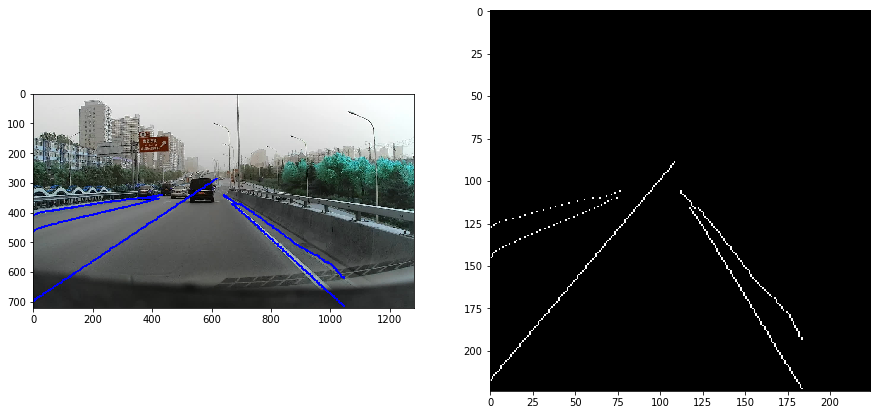

In [81]:
img = plt.imread(day_image_path[0])
print(day_image_path[0].split('/'))
lines = pipeline(img)
lines_img = lines_to_img(lines, DATA_SHAPE)
draw_img = draw_lines(img, lines)
r,g,b = cv2.split(draw_img)
draw_img = cv2.merge([b,g,r])
cv2.imwrite('vids/result/'+day_image_path[0].split('/')[1] +'/'+day_image_path[0].split('/')[2], draw_img)


fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(draw_img)
axs[1].imshow(lines_img, cmap='gray')
plt.show()